# Simulation Workflow Execution — Usage Guide

This notebook introduces the `Pipeline` class used to build and run full or partial **simulation workflows** in ChestXSim. *mention somethiong we mix all we learn form previous notebooks into unified blabla..so far we have introduce basic data formats cordenate conventions project structure, steps form different modules , readiing and saving logic, here we put all together using unified execution ...
It covers how to:
- **Create a pipeline** by adding steps programmatically *or* from a **configuration dict**.
- **Run full or partial simulations** using the `mode` selector (preprocessing / projection / reconstruction).

### Overview 
The `Pipeline`class is a unified orchestrator that executes a **sequence od callable steps** on a `VolumeData`object. 
We recall from previous notebooks that a `step` is simply a class with ith `__call__(ct: volumeData) -> volumeData` and performs one operation and logs its attributes to `metadata` to tack the process.  
the pipeline just execute the registered steps sequentially and hangles saving. 

Supports **manual construction** (`.add(...)`) or **config-driven** assembly (`build_pipeline(...)`).

**Geometry & Operators**  
When building from config, the pipeline can **inject geometry** and **create an operator** (e.g., ASTRA) for steps like `Projection` or `FDK`.  
Operators are **cached** per kernel name to avoid repeated construction.

**How saving works (automatic via `Pipeline`):**
- Each `save=True` step writes:
  - the **binary volume** (`.img`),
  - **`info.txt`** (dims, voxel size, dtype, etc.),
  - **`log.txt`** (copy of `metadata.step_outputs`).
- The base folder is set in `Pipeline(base_save_dir="...")`.
- It Uses `PROCESSING_STEP_REGISTRY` names to map steps class name to default folder names.  




### Create an End-to-End Pipeline from Scratch (manual)

In [1]:
from chestxsim.io import DicomReader, RawReader
from chestxsim.core import TomoGeometry, Pipeline, SourceSpectrum
from chestxsim.wrappers import ASTRA_Tomo
from chestxsim.preprocessing import *
from chestxsim.projection import *
from chestxsim.reconstruction import *
from chestxsim.utility import plot 

GPU detected: Using CuPy with 1 device(s), current device: 0


In [2]:
from chestxsim.core import build_pipeline
from chestxsim.io import RawReader
from pathlib import Path 

dicom_folder = r"D:\bhermosi\chestxsim-project\inputs\NODULO\S18\S20"
reader = DicomReader(convert_to_HU=True, clip_values=(-1024.0, 3000.0))
ct_data = reader.read(dicom_folder)

# # define system we are simulating: geometry + source

source = SourceSpectrum(I0=1e5, voltage=120, poly_flag=True) 
geo = TomoGeometry(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    bucky=14.47,
    step_mm=16.077,
    nprojs=60
)

dct_system = ASTRA_Tomo(geometry=geo)

# configure steps manually:: 

# ---- preprocesssing 
step_bed = BedRemover(threshold=-200, save_mask=True)
step_air = AirCropper(axis=1, tol=5, delta=3, channel=0)
step_ext = VolumeExtender(ext_vals_mm=[100,100])
step_seg = TissueSegmenter(threshold=300, tissue_types=["bone", "soft"], save_masks=True)
step_rho = UnitConverter(units="density", tissue_types=["bone","soft"], mu_factor=[2.0,1.0])
# ---- projection 
step_proj  = Projection(opt=dct_system, channel_wise=True)
step_phys  = PhysicsEffect(source=source, ISL=False, apply_flood_correction=False, log=False)
step_noise = NoiseEffect(mu_dark=2.0, sigma_dark=6.0, inhomgeneities_map=None,
                         apply_flood_correction=True, log=True)
# ---- reconstruction
step_fdk = FDK(opt=dct_system, match_input=True, reco_vx=(1.25, 5.00, 1.25),
               filter_type="ramp", axis=1, padding=True)

# build and run pipeline ::.
pipe = Pipeline(base_save_dir="results")
pipe.add(step_bed,  save=False)  # save ct no bed for reuse
pipe.add(step_air,  save=True)
pipe.add(step_ext,  save=False)
pipe.add(step_seg,  save=False)
pipe.add(step_rho,  save=True)   # save density volume for reuse
pipe.add(step_proj, save=True)
pipe.add(step_phys, save=True)
pipe.add(step_noise,save=True)   # save projections for reuse 
pipe.add(step_fdk,  save=True)   # save reconstructed volume for reuse 

out = pipe.execute(ct_data)


# show DCT reconstructed volume 
# plot(out.volume.get()[:, out.volume.shape[1]//2, :, 0].T)

[Pipeline] Pipeline execution started.
[Pipeline] Number of steps: 9
[Pipeline] (0/9) BedRemover — running
[BedRemover] Saving mask to: D:\bhermosi\chestxsim-project\results\CT_bed_mask\NODULO_S18_S20_vx_0.84_0.84_1.25_dim_512_512_276.img
[Pipeline] 0/9) BedRemover — done
[Pipeline] (1/9) AirCropper — running
[Pipeline] 1/9) AirCropper — done
[SaveManager] AirCropper result saved to: results\CT_air_cropped\NODULO_S18_S20
[Pipeline] (2/9) VolumeExtender — running
[Pipeline] 2/9) VolumeExtender — done
[Pipeline] (3/9) TissueSegmenter — running
[TissueSegmenter] Saving bone mask (analytical) to: D:\bhermosi\chestxsim-project\results\CT_tissue_masks\analytical\NODULO_S18_S20_bone_analytical_vx_0.84_0.84_1.25_dim_512_347_436.img
[TissueSegmenter] Saving soft mask (analytical) to: D:\bhermosi\chestxsim-project\results\CT_tissue_masks\analytical\NODULO_S18_S20_soft_analytical_vx_0.84_0.84_1.25_dim_512_347_436.img
[Pipeline] 3/9) TissueSegmenter — done
[Pipeline] (4/9) UnitConverter — running


In [3]:
out.volume.shape

(344, 86, 276, 1)

### Build a Pipeline from a configuration dict 
Here we show a configuration dictionary exmaple that can be similarly loaded in a json file it jsut define steps attibutes then the configuratin of steps is done by the `build_pipeline` method. 
it can select the module execuition with mode flag  

[Pipeline] Building simulation pipeline...
[Pipeline] Geometry initialized (DCT) with 61 projections.
[Pipeline] Added step: BedRemover (save=True)
[Pipeline] Added step: AirCropper (save=True)
[Pipeline] Added step: VolumeExtender (save=False)
[Pipeline] Added step: TissueSegmenter (save=False)
[Pipeline] Added step: UnitConverter (save=True)
[Pipeline] Pipeline configuration completed.
[Pipeline] Initialized operator 'astra'.
[Pipeline] Added step: Projection (save=True)
[Pipeline] Added step: PhysicsEffect (save=True)
[Pipeline] Added step: NoiseEffect (save=True)
[Pipeline] Pipeline configuration completed.
[Pipeline] Added step: FDK (save=True)
[Pipeline] Pipeline configuration completed.
[Pipeline] Pipeline execution started.
[Pipeline] Number of steps: 9
[Pipeline] (0/9) BedRemover — running
[Pipeline] 0/9) BedRemover — done
[SaveManager] BedRemover result saved to: results\CT_without_bed\NODULO_S18_S20
[Pipeline] (1/9) AirCropper — running
[Pipeline] 1/9) AirCropper — done
[Sav

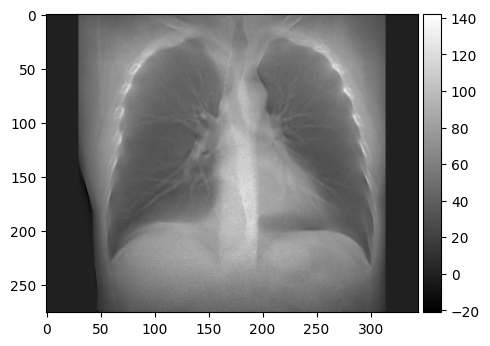

In [4]:
from chestxsim.core import build_pipeline
from chestxsim.io import RawReader
from pathlib import Path 

config = { 
    "modality": "DCT",  
    "geometry": {
        "detector_size": (4288, 4288),
        "pixel_size": (0.1, 0.1),
        "binning_proj": 4,
        "SDD": 1800.0,
        "bucky": 14.47,
        "step_mm": 16.077,
        "nprojs": 61
    },
    "preprocessing": {
        "bed_removal":   {"threshold": -200, "save_mask":False, "save": True},
        "air_cropping":  {"axis": 1, "tol": 5, "delta": 3, "channel": 0, "save": True},
        "volume_extension": {"target_height": 600.0, "chest_center": 150, "save": False},
        "tissue_segmentation": {"threshold": 300, "tissue_types": ["bone","soft"], "save": False},
        "unit_conversion": {"units": "density", "tissue_types": ["bone","soft"], "save": True}
    },
    "projection": {
        "projection":     {"opt": "astra", "channel_wise": True, "save": True},
        "Physics_effect": {"I0": 1e5, "voltage": 120, "poly_flag": True,
                           "ISL": False, "apply_flood_correction": False, "log": False, "save": True},
        "noise_effect":   {"mu_dark": 2.0, "sigma_dark": 6.0, "apply_flood_correction": True, "log": True, "save": True}
    },
    "reconstruction": {
        "FDK": { "opt": "astra", "match_input": True, "reco_vx": (1.25, 5.00, 1.25),
                "filter_type": "ramp", "axis": 1, "padding": True, "save": True}

}
}

# # Full chain (preprocessing → projection → reconstruction)
pipe_all = build_pipeline(config, mode=None, output_folder="results")
out_all = pipe_all.execute(ct_data)

plot(out_all.volume.get()[:, out_all.volume.shape[1]//2, :, 0].T)

In [5]:
# run just projection for already preprocessed data
# load projs 
from chestxsim.core import build_pipeline
from chestxsim.io import RawReader
from pathlib import Path 

reader = RawReader()
base_path= Path(r"D:\bhermosi\chestxsim-project\examples\notebooks\results\CT_converted")
case_id = "NODULO_S18_S20"
density_data = reader.load_multi_tissue(base_path/"density", case_id, combine_method="stack")

pipe_proj = build_pipeline(config, mode=1, output_folder="results")
out_proj = pipe_proj.execute(density_data)


[RawReader] Found tissue 'bone' at D:\bhermosi\chestxsim-project\examples\notebooks\results\CT_converted\density\bone\NODULO_S18_S20
[RawReader] Found tissue 'soft' at D:\bhermosi\chestxsim-project\examples\notebooks\results\CT_converted\density\soft_tissue\NODULO_S18_S20
[Pipeline] Building simulation pipeline...
[Pipeline] Geometry initialized (DCT) with 61 projections.
[Pipeline] Initializing pipeline for projection
[Pipeline] Initialized operator 'astra'.
[Pipeline] Added step: Projection (save=True)
[Pipeline] Added step: PhysicsEffect (save=True)
[Pipeline] Added step: NoiseEffect (save=True)
[Pipeline] Pipeline configuration completed.
[Pipeline] Pipeline execution started.
[Pipeline] Number of steps: 3
[Pipeline] (0/3) Projection — running
[Pipeline] 0/3) Projection — done
[SaveManager] Saved bone channel to: results\Projections\bone\NODULO_S18_S20_3
[SaveManager] Saved soft channel to: results\Projections\soft_tissue\NODULO_S18_S20_3
[Pipeline] (1/3) PhysicsEffect — running
[P